# Modelo SchNet (Pytorch)


*   n_atom_basis=30
*   n_filters=10
*   n_gaussians=25
*   n_interactions=5
*   cutoff=4.
*   cutoff_network=CosineCutoff
*   Adam 1e-2
*   ReduceLROnPlateauHook hasta 1e-6



In [ ]:
!pip install schnetpack
!pip install ase
!pip install nglview
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pandas as pd
from  schnetpack import AtomsData
import schnetpack as spk
import schnetpack.train as trn
from ase.io import read
from ase.visualize.plot import plot_atoms
from ase.lattice.cubic import FaceCenteredCubic
from torch.optim import Adam
import torch
qmH2O = '/content/drive/My Drive/Colab Notebooks/SchNet Files/qmH2O_10/'
SchNet_Files = '/content/drive/My Drive/Colab Notebooks/SchNet Files/'
Files = '/content/drive/My Drive/Colab Notebooks/'
device = 'cuda'

     |████████████████████████████████| 266kB 13.7MB/s 
     |████████████████████████████████| 2.2MB 26.0MB/s 
     |████████████████████████████████| 317kB 51.8MB/s 
     |████████████████████████████████| 5.2MB 12.1MB/s 
  Created wheel for nglview: filename=nglview-2.7.7-cp36-none-any.whl size=6983522 sha256=783140639a75b5925d97fecc3a01f5d0c3ec20eef3a379fcc7a5fdcd3f330d19
  Stored in directory: /root/.cache/pip/wheels/24/14/56/fc0406301850d9d017a748b568b2e97566148deda046ac56dc
Successfully built nglview


# DB ASE 
Se carga DB ASE si existe(SQL Lite para átomos y moléculas), en caso contrario se crea el fichero de DB vacío 

In [ ]:
new_dataset = AtomsData(SchNet_Files + 'new_dataset_H2O.db')

# Carga de datos en DB a partir de fichero en formato xyz
# Comentado! 
Esto se hace una vez en local y sirve para todos los entrenamnientos

1.   Se importa el archivo xyz con la información de las 
moléculas y sus propiedades. En nuestro caso:
*   Posición de los átomos
*   Energía



In [ ]:
#atoms = read('/content/drive/My Drive/Colab Notebooks/output_h2o_HF_ccpvdz_to_SchNet.xyz', index=':17636')
#print(len(atoms))

17636


2.   Se pueden visualizar las moléculas



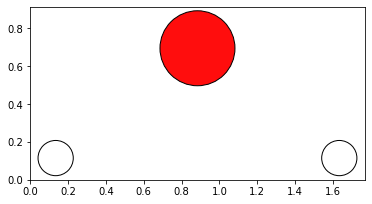

In [ ]:
#fig, ax = plt.subplots()
#plot_atoms(atoms[12852], ax, radii=0.3, rotation=('0x,0y,-90z'))

3.   Se crea una lista, solo con las propiedades que no sean posiciones espaciales o vectores de fuerza. En nuestro caso la energía.

In [ ]:
#print('Energy:', atoms[12852].info)

# parse properties as list of dictionaries
#property_list = []
#for at in atoms:
#    energy = np.array([float(list(at.info.keys())[0])], dtype=np.float32)
#    property_list.append(
#        {'energy': energy}
#    )
#print(property_list[12852])
#len(property_list)

Energy: {'-76.027388': True}
{'energy': array([-76.02739], dtype=float32)}


17636

4.   Se carga la información en la DB de forma persistente


In [ ]:
#new_dataset.add_systems(atoms, property_list)

# Creación del conjunto de entrenamiento y validación
Test se deja a cero porque disponemos de un dataset propio.

La partición aleatoria queda reflejada en el archivo split.npz

Si ya existe split.npz mantiene la partición.

Se valida con el 10% (1736) del total del os datos (17363)

In [ ]:
train, val, test = spk.train_test_split(
        data=new_dataset,
        num_train=15627,
        num_val=1736,
        split_file= qmH2O +'split.npz',
    )

Comprobamos que hay datos

In [ ]:
train.get_properties(15626)
val.get_properties(1735)

/usr/local/lib/python3.6/dist-packages/schnetpack/data/atoms.py:327: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  properties[pname] = torch.FloatTensor(prop)
/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


(Atoms(symbols='OH2', pbc=False),
 {'_atomic_numbers': tensor([8, 1, 1]), '_cell': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]), '_cell_offset': tensor([[[0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.]]]), '_neighbors': tensor([[1, 2],
          [0, 2],
          [0, 1]]), '_positions': tensor([[-0.0687, -0.0174,  0.0000],
          [ 0.6885,  0.8017,  0.0000],
          [ 0.4012, -0.5257,  0.0000]]), 'energy': tensor([-75.8642])})

# Creación de Data Loaders

In [ ]:
train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=20)

# Cálculo de las estadísticas de las propiedades

In [ ]:
atomrefs = new_dataset.get_atomref('energy')
means, stddevs = train_loader.get_statistics(
    property_names ='energy', single_atom_ref=atomrefs
)
print('Mean atomization energy / atom:', means['energy'])
print('Std. dev. atomization energy / atom:', stddevs['energy'])

/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


Mean atomization energy / atom: tensor([-75.7421])
Std. dev. atomization energy / atom: tensor([0.4279])


# Definición del modelo


1.   Se define el modelo que representación al sistema
2.   Se define la la salida que proporciona la energía a partir del modelo anterior.
2.   Se unen en un mismo modelo



In [ ]:
schnet = spk.representation.SchNet(
    n_atom_basis=30, n_filters=10, n_gaussians=25, n_interactions=5,
    cutoff=4., cutoff_network=spk.nn.cutoff.CosineCutoff
)

output_E = spk.atomistic.Atomwise(n_in=30, atomref=atomrefs['energy'], property='energy',
                                   mean=means['energy'], stddev=stddevs['energy'])

model = spk.AtomisticModel(representation=schnet, output_modules=output_E)

# Definición del Trainer con:
*   Optimizador
*   Función de pérdida mse
*   Métrica MeanAbsoluteError
*   Reducción progresiva de lr con ReduceLROnPlateauHook
*   Ruta donde se guardará el mejor modelo, logs y checkpoints
*   Conjunto de datos de train y validation



In [ ]:
optimizer = Adam(model.parameters(), lr=1e-2)
loss = trn.build_mse_loss(['energy'])
metrics = [spk.metrics.MeanAbsoluteError('energy')]
hooks = [
    trn.CSVHook(log_path=qmH2O, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=3, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]
trainer = trn.Trainer(
    model_path=qmH2O,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

# Entrenamiento del modelo

In [ ]:
n_epochs = 1000

datetime_comienzo = datetime.now()

trainer.train(device=device, n_epochs=n_epochs)

datetime_fin = datetime.now()
print("Tiempo de entrenamiento:" + str(datetime_fin-datetime_comienzo) )

/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


Tiempo de entrenamiento:5:02:00.153688


# Resultado del entrenamiento

In [ ]:
results = np.loadtxt(qmH2O + 'log.csv', skiprows=1, delimiter=',') #Se lee el archivo de logs

time = results[:,0]-results[0,0]
learning_rate = results[:,1]
train_loss = results[:,2]
val_loss = results[:,3]
val_mae = results[:,4]

print('Final train Loss:', np.round(train_loss[-1], 6))
print('Final validation Loss:', np.round(val_loss[-1], 6))
print('Final validation MAE:', np.round(val_mae[-1], 6))

Final train Loss: 0.00051
Final validation Loss: 7.2e-05
Final validation MAE: 0.005754


## Loss durante el entrenamiento

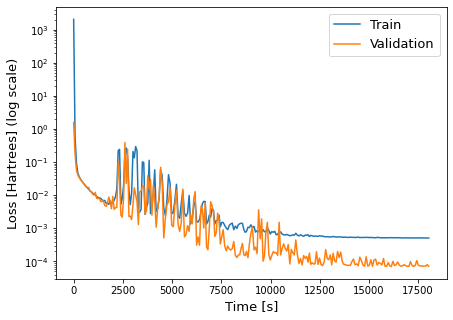

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(time, train_loss, label='Train')
plt.plot(time, val_loss, label='Validation', color='tab:orange')
plt.yscale('log')
plt.ylabel('Loss [Hartrees] (log scale)', fontsize=13)
plt.xlabel('Time [s]', fontsize=13)
plt.legend(fontsize=13)
plt.show()

## Métrica en validación, durante el entrenamiento

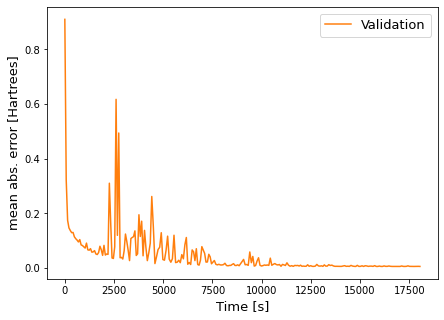

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(time, val_mae, label='Validation', color='tab:orange')
plt.ylabel('mean abs. error [Hartrees]', fontsize=13)
plt.xlabel('Time [s]', fontsize=13)
plt.legend(fontsize=13)
plt.show()

# Carga del mejor modelo

In [ ]:
best_model = torch.load(qmH2O + 'best_model')

# Validación modelo

In [ ]:
valid_loader = spk.AtomsLoader(val, batch_size=1, shuffle=False)

err = 0
print(len(valid_loader))
for count, batch in enumerate(valid_loader):
    # move batch to GPU, if necessary
    batch = {k: v.to(device) for k, v in batch.items()}

    # apply model
    pred = best_model(batch)

    tmp = torch.sum(torch.abs(pred['energy']-batch['energy']))
    tmp = tmp.detach().cpu().numpy()
    err += tmp

err /= len(valid_loader)
print('Error MAE: {:.6f}'.format(err))

1736


/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


Error MAE: 0.005723


# Carga del conjunto Test
*   Como DB
*   Como DataFrame (a apartir de CSV)

Guardan el mismo orden


In [ ]:
atomstest = AtomsData(SchNet_Files + 'new_dataset_H2O_test.db')
#testeamos de 1 en 1 (aunque podría hacerse en conjuntos mayores)
atomstest_loader = spk.AtomsLoader(atomstest, batch_size=1, shuffle=False)
print(len(atomstest_loader))
#Dataframe con los mismo datos que la BD anterior. en este Data Frame, también se irán cargando las predicciones.
data_df_test = pd.read_csv(Files + "output_plotdata_ccpvdz_HF_test.csv")
data_df_test['energy_t']= np.nan
data_df_test['pred']= np.nan

1577


# Test del modelo
Cálculo del MAE

In [ ]:

err = 0
for count, batch in enumerate(atomstest_loader):
 batch = {k: v.to(device) for k, v in batch.items()}
 # apply model
 pred = best_model(batch)
 data_df_test.loc[count,'penergy_t'] = batch['energy'].detach().cpu().numpy()[0][0]
 data_df_test.loc[count,'pred'] = pred['energy'].detach().cpu().numpy()[0][0]
 # calculate absolute error
 tmp = torch.sum(torch.abs(pred['energy']-batch['energy']))
 tmp = tmp.detach().cpu().numpy() 
 err += tmp
 
err /= len(atomstest)
print('Error MAE: {:.6f}'.format(err))

/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


Error MAE: 0.005729


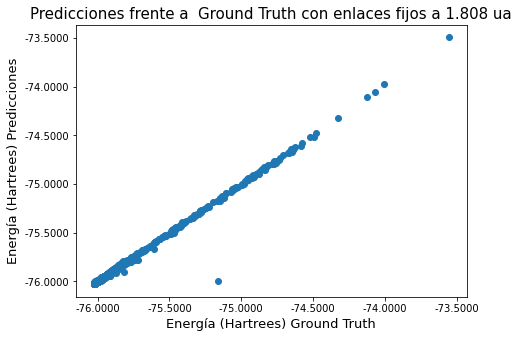

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(data_df_test['energia'], data_df_test['pred'])
ax.set_title('Predicciones frente a  Ground Truth con enlaces fijos a 1.808 ua', fontsize=15)
ax.set_xlabel('Energía (Hartrees) Ground Truth', fontsize=13)
ax.set_ylabel('Energía (Hartrees) Predicciones', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.show()

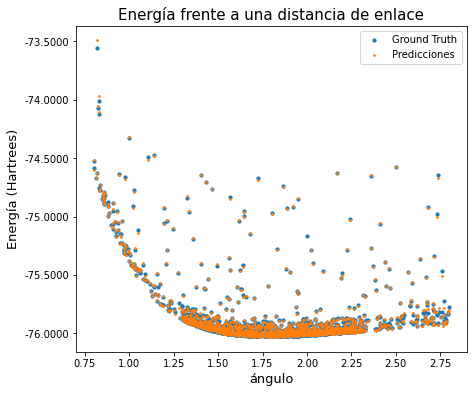

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

ax.scatter(data_df_test['rh1'], data_df_test['energia'], label='Ground Truth', s=10)
ax.scatter(data_df_test['rh1'], data_df_test['pred'], label='Predicciones', s=3)
ax.set_title('Energía frente a una distancia de enlace', fontsize=15)
ax.set_xlabel('ángulo', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend()

plt.show()

# Energía frente a una distancia de enlace
Fijando la otra distancia de enlace a 1.808 ua y el ángulos a 104.5 grados

In [ ]:
atomsdata0 = AtomsData(SchNet_Files + 'new_dataset_H2O_continua.db')
atomsdata0_loader = spk.AtomsLoader(atomsdata0, batch_size=1, shuffle=False)
best_model = torch.load(qmH2O + 'best_model')
print(len(atomsdata0_loader))
data_df0 = pd.read_csv(Files + "output_plotdata_HF_ccpvdz_continua.csv")
data_df0['energy_t']= np.nan
data_df0['pred']= np.nan

err = 0
for count, batch in enumerate(atomsdata0_loader):
 batch = {k: v.to(device) for k, v in batch.items()}
 # apply model
 pred = best_model(batch)
 data_df0.loc[count,'penergy_t'] = batch['energy'].detach().cpu().numpy()[0][0]
 data_df0.loc[count,'pred'] = pred['energy'].detach().cpu().numpy()[0][0]
 # calculate absolute error
 tmp = torch.sum(torch.abs(pred['energy']-batch['energy']))
 tmp = tmp.detach().cpu().numpy() # detach from graph & convert to numpy
 err += tmp

err /= len(atomsdata0)
print('Error MAE: '+ str(err))

8424


/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


Error MAE: 0.008743345907271079


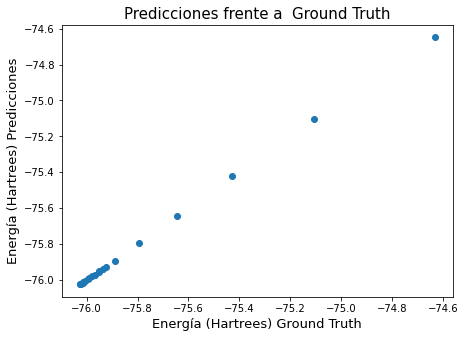

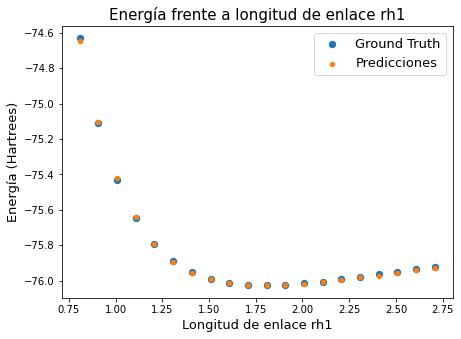

In [ ]:
data_long_enlace = data_df0[(np.round(data_df0["ang"],1)==104.5) & (np.round(data_df0["rh2"],3)==1.808)].copy()

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(data_long_enlace['energia'], data_long_enlace['pred'])
ax.set_title('Predicciones frente a  Ground Truth', fontsize=15)
ax.set_xlabel('Energía (Hartrees) Ground Truth', fontsize=13)
ax.set_ylabel('Energía (Hartrees) Predicciones', fontsize=13)


fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(data_long_enlace['rh1'], data_long_enlace['energia'], label='Ground Truth', s=40)
ax.scatter(data_long_enlace['rh1'], data_long_enlace['pred'], label='Predicciones', s=20)
ax.set_title('Energía frente a longitud de enlace rh1', fontsize=15)
ax.set_xlabel('Longitud de enlace rh1', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.legend(fontsize=13)
plt.show()

# Energía frente al ángulo

Fijando las dos distancias de enelace a 1.808

In [ ]:
data_ang = data_df0[(np.round(data_df0['rh1'],3)==1.808) & (np.round(data_df0['rh2'],3)==1.808)].copy()

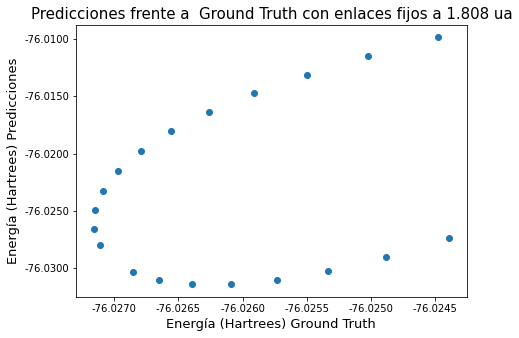

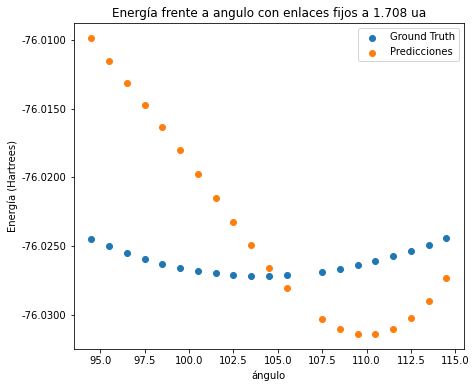

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(data_ang['energia'], data_ang['pred'])
ax.set_title('Predicciones frente a  Ground Truth con enlaces fijos a 1.808 ua', fontsize=15)
ax.set_xlabel('Energía (Hartrees) Ground Truth', fontsize=13)
ax.set_ylabel('Energía (Hartrees) Predicciones', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.show()

fig, ax = plt.subplots(figsize=(7,6))

ax.scatter(data_ang['ang'], data_ang['energia'] , label='Ground Truth')
ax.scatter(data_ang['ang'], data_ang['pred'] , label='Predicciones')
ax.set_title('Energía frente a angulo con enlaces fijos a 1.708 ua')
ax.set_xlabel('ángulo')
ax.set_ylabel('Energía (Hartrees)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend()

plt.show()

Fijando las dos distancias de enelace a 1.708

In [ ]:
data_ang = data_df0[(np.round(data_df0['rh1'],3)==1.708) & (np.round(data_df0['rh2'],3)==1.708)].copy()

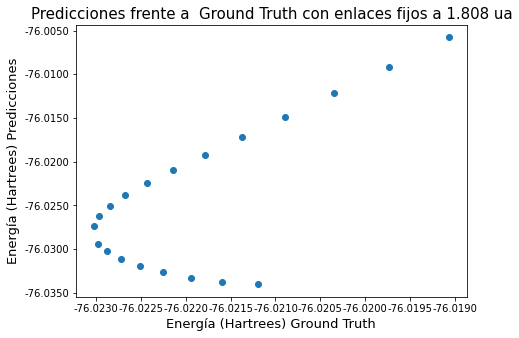

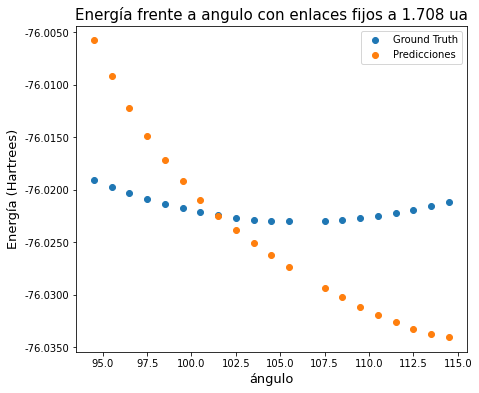

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(data_ang['energia'], data_ang['pred'])
ax.set_title('Predicciones frente a  Ground Truth con enlaces fijos a 1.808 ua', fontsize=15)
ax.set_xlabel('Energía (Hartrees) Ground Truth', fontsize=13)
ax.set_ylabel('Energía (Hartrees) Predicciones', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.show()

fig, ax = plt.subplots(figsize=(7,6))

ax.scatter(data_ang['ang'], data_ang['energia'] , label='Ground Truth')
ax.scatter(data_ang['ang'], data_ang['pred'] , label='Predicciones')
ax.set_title('Energía frente a angulo con enlaces fijos a 1.708 ua', fontsize=15)
ax.set_xlabel('ángulo', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend()

plt.show()